### Beispiel eines Neuronalen Netzes zur Vorhersage von Kundenabwanderung
Genutzt wird in diesem Fall ein **LSTM**-Netz (Long-Short-Term-Memory)
, welches besonders gut für die Analyse von längeren Sequenzen (Texte, Kursverläufe etc.) geeignet ist.
In unserem Fall sind dies Bestellverläufe verschiedener Kunden. Ziel ist es, das Netz auf einen Teil der Kundenbestellungen zu trainieren, und mit dem Rest zu testen ob das System diese richtig als abgesprungen oder nicht abgesprungen klassifiziert.

Im folgenden finden Sie die Codefragmente mit den zugehörigen Beschreibungen. Diese müssen nacheinander von Ihnen ausgeführt werden.

Import der notwendigen Bibliotheken:
* **Keras** - Hauptframework für Machine Learning. (Basiert auf Google's Tensorflow)
* **Numpy** - Unter anderem zur Durchführung von Vektorberechnungen.
* **Pandas** - Regelt den Import und die Formatierung von Daten. 

In [1]:
import random as rn
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dateutil.relativedelta import relativedelta
from keras_preprocessing.sequence import pad_sequences
from numpy.random import seed
from reader import *
from models import *

Using TensorFlow backend.


Funktion, welche fehlende Daten einer Zeitreihe auffüllt.

In [2]:
def fill_dates(df, end_date):
    start_date = df['date'].iloc[0]
    if start_date > end_date or len(df) == 0:
        return df
    diff = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)
    date_list = [start_date + relativedelta(months=x) for x in range(0, diff)]
    date_frame = pd.DataFrame(date_list)
    date_frame.columns = ['date']
    value = pd.merge(date_frame, df, how='left').fillna(0)
    value = value.drop(['date'], axis=1)
    return value

Funktion, welche einen Datensatz in einem gewählten Verhältnis teilt.

In [3]:
def test_train_test_split(train_test_split):
    
    data = np.random.rand(620,4,3,2,1)
    ratios = [0.0, 0.3, 0.6, 1.0]
    
    for ratio in ratios:
        try:
            splitted_data = train_test_split(data, ratio)
            assert len(splitted_data) == 2
            data_test, data_train = splitted_data
            
            test_shape = data_test.shape
            train_shape = data_train.shape
            
            for i, (s1, s2) in enumerate(zip(test_shape, train_shape)):
                if i == 0:
                    train_shape_asserted = int(data.shape[0] * ratio)
                    test_shape_asserted = int(data.shape[0] * (1-ratio))
                    assert s1 == train_shape_asserted, f'train len.: {train_shape_asserted}, deine train len.: {s1}'
                    assert s2 == test_shape_asserted, f'test len.: {test_shape_asserted}, deine train len.: {s2}'
                else:
                    error_msg = (
                        f'Die anderen Dimensionen von test und Train stimmen nicht überein!\n'
                        f'Alle Dimensionen von Test: {test_shape}\n'
                        f'Alle Dimensionen von Train: {train_shape}\n'
                    )
                    assert s1 == s2, error_msg
        except AssertionError as e:
            print(e)
            return
    print('Test erfolgreich!')

def train_test_split(df, ratio):
    """
    Args:
        df (:obj:`pandas.DataFrame`): DataFrame der gesplittet werden soll
        ...
    """
    train = np.array(df[:round(len(df) * ratio)])
    test = np.array(df[round(len(df) * ratio):])
    return train, test

In [4]:
test_train_test_split(train_test_split)

Test erfolgreich!


Funktion, welche *Random-Seeds* setzt.

In [5]:
def set_random_seed(s):
    seed(s)
    rn.seed(s)
    tf.random.set_seed(s)

Einlesen der Daten mithilfe von **Pandas**
* Es wird zwischen X und Y-Werten unterschieden.
* Die X-Werte sind in unserem Fall die Bestellverläufe.
* Der Y-Wert ist ein *boolean*-Wert, welcher besagt ob ein Kunde abgesprungen ist.

In [6]:
x_data, y_data = read_and_clean_data('cleaned_orders.csv', 'cleaned_y_data.csv')

Kleiner Ausschnitt der X und y-Werte:

In [7]:
print(x_data.head(10))
print(x_data.shape)

     recipient       date   sales
808      11675 2015-06-01  1014.0
809      11675 2015-07-01  4630.0
810      11675 2015-08-01  1425.0
811      11675 2015-09-01   532.0
812      11675 2015-10-01  3656.0
813      11675 2015-11-01  1272.0
814      11675 2015-12-01  2799.0
815      11675 2016-01-01   671.0
816      11675 2016-02-01  5232.0
817      11675 2016-04-01  2119.0
(2112, 3)


In [8]:
print(y_data.head(10))
print(y_data.shape)

   recipient  churned
0      11675        0
1      12589        0
2      13593        1
3      14080        1
4      14089        0
5      14094        0
6      14095        1
7      14098        1
8      14100        0
9      14103        1
(352, 2)


Die Daten müssen im Folgenden so angepasst werden, dass sie ein passendes Format für sowohl RNNs als auch normale FFs aufweisen.

## RNN Datenanpassung

Für die Daten eines RNNs müssen die verschiedenen `recipients` bezüglich der `dates` gruppiert werden, so dass jeder `recipient` als Input des Netzwerkes dient.<br>
Die drei folgenden Code-Zellen dienen der Transformation der X-Werte in ein 3D-Array.

In [9]:
x_data_dict =  dict()
x_data_grouped = x_data.groupby('recipient')
for recipient in x_data_grouped.groups:
    x_data_dict[recipient] = pd.DataFrame(x_data_grouped['date','sales'].get_group(recipient))
assert len(x_data_dict) == len(y_data)

In [10]:
X_RNN = list()
for key, item in x_data_dict.items():
    X_RNN.append(fill_dates(item, datetime.strptime("2018-09-01","%Y-%m-%d")).values.tolist())

Da RNNs standardmäßig gleichlange Eingaben verlangen, findet ein **Padding** statt

In [11]:
X_RNN = pad_sequences(X_RNN, value=-1,dtype='float32')
y_RNN = np.array(y_data['churned'].values)
y_RNN = y_RNN.reshape(y_RNN.shape[0],1)

print(f'y shapes: {y_RNN.shape} -> keine Änderung')
print(f'X shapes: {X_RNN.shape} -> Änderungen')


y shapes: (352, 1) -> keine Änderung
X shapes: (352, 43, 1) -> Änderungen


Was kann man daraus ablesen?<br>
Insgesamt gibt es 352 `recipients`, wobei jeder nach dem Padding einer Zeitspanne von 43 Monaten mehrere Käufe tätigt.

Aufteilung der Daten in 70% Trainings- und 30% Testdaten:

In [12]:
X_test_RNN, X_train_RNN = train_test_split(X_RNN, 0.3)
y_test_RNN, y_train_RNN = train_test_split(y_RNN, 0.3)
print(X_test_RNN.shape, X_train_RNN.shape)

(106, 43, 1) (246, 43, 1)


**An dieser Stelle sind Sie gefragt..**
Das nachfolgende Codefragment enthält 4 modifizierbare Parameter, welche essenziell für die Genauigkeit des Netzwerks sind.
Diese sind so initialiert, dass das Netwerk ohne Veränderung eine schlechte Performance aufweist.
Ihre Aufgabe ist es nun diese Parameter so anzupassen, dass eine möglichst hohe Genauigkeit erzielt wird.

Die Parameter sind wie folgt beschrieben:
* **learning_rate**: Lernrate des Minimierungs-Algorithmus der Kostenfunktion (default: 0.00001, range: 0-∞)
* **lstm_cells**: Anzahl der Memory-Cells des Netzwerks. Besitzt ein Netzwerk mehr Zellen, kann es sich eine größere Anzahl an Merkmalen merken. Zu viele können zu *Overfitting* führen. (default: 1, range: 1-∞)
* **dropout**: Anteil der Merkmale, die zufällig gelöscht werden. Wirkt *Ovefitting* entgegen (default: 0.5, range: 0-1)
* **epochs**: Anzahl der Traingsdurchläufe (default: 10, range: 1-∞)

In [13]:
params = {
    "learning_rate": 0.1,
    "lstm_cells": 100,
    "dropout": 0,
    "epochs": 50,
}

In [14]:
set_random_seed(120)

workshop_lstm = WorkshopLSTM(params)
workshop_lstm.build(X_train_RNN)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 43, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None


Die nachfolgende Code-Zelle enthält den Aufruf der *fit*-Methode, welche das Training des Netzes mit den oben angegebenen Parametern startet. Anschließend wird eine Zusammenfassung des Traingsverlaufs ausgegeben.

In [15]:
workshop_lstm.fit_and_evaluate(X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN)

Train on 246 samples, validate on 106 samples
Epoch 1/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7696 - acc: 0.7114 - val_loss: 0.3392 - val_acc: 0.8774
Epoch 2/50
246/246 [==============================] - 1s 3ms/step - loss: 0.4217 - acc: 0.7886 - val_loss: 0.3957 - val_acc: 0.8208
Epoch 3/50
246/246 [==============================] - 1s 4ms/step - loss: 0.3869 - acc: 0.7520 - val_loss: 0.3780 - val_acc: 0.8679
Epoch 4/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3371 - acc: 0.8496 - val_loss: 0.3422 - val_acc: 0.9151
Epoch 5/50
246/246 [==============================] - 1s 2ms/step - loss: 0.2981 - acc: 0.8496 - val_loss: 0.2986 - val_acc: 0.8868
Epoch 6/50
246/246 [==============================] - 0s 2ms/step - loss: 0.2826 - acc: 0.8537 - val_loss: 0.2947 - val_acc: 0.8962
Epoch 7/50
246/246 [==============================] - 0s 2ms/step - loss: 0.2952 - acc: 0.8699 - val_loss: 0.3706 - val_acc: 0.8208
Epoch 8/50
246/246 [==========

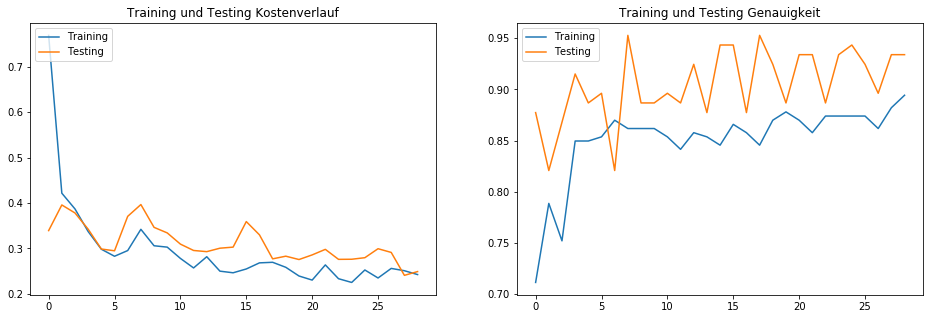

Genauigkeit: 93.40%
99 von 106 Beispielen richtig klassifiziert!


In [16]:
workshop_lstm.plot()
workshop_lstm.print_scores(X_test_RNN)